# GoLIVE notebook 1


## Create data volume

This repo is intended to contain only the source code, and can be cloned to the home directory (`~`) of a compute environment such as Pangeo. By default the data directory will be at `~/data/golive_big`, which we will create and populate with data in this notebook. 

One of the upper Python cells (see below) begins with `if False:` and continues to use Python FTP to
pull a bunch of data. When you are ready to download data, change `False` to `True` and execute that cell. This is so that no time-consuming and possibly redundant data downloading proceed automatically. 

## Section 1. Take stock of a retrieved dataset 

**Location: southeast Alaska, Landsat 8 Path 63 Row 18**


The science motivation here is simply 'What sort of variability in glacier speed is 
to be found in the data?' 


> *Abstract*
>
> 
> Region-wide variability in glacier speed should have discernible cause. For a time and location window 
> provided by GoLIVE we assess patterns in glacier speed on scales from 100 meters to 200 km. 
> Normalized variability should (null hypothesis) be moderated by observables, particularly precipitation 
> and temperature as they moderate bed conditions. 
> 


The following cells:

- sets up inline graphics via `matplotlib`
- ensures the `utm`, `pygeotools` and `tqdm` packages are installed in this environment. `tqdm` is for drawing progress bars
- imports a set of useful packages
- imports a set of utility methods from the local file `golive_library.py`
  - these are subsequently referenced using a `g.` prefix

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

# automatically reload external modules such as golive_library if they have changed
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install utm
!pip install pygeotools
!pip install tqdm

%matplotlib inline

# Python Standard Library built-in modules
import sys
import os
import timeit
from datetime import timedelta, datetime
from random import randint as ri

# Third-party modules
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import dask
import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64
from scipy import stats
from scipy.signal import medfilt as mf
from ftplib import FTP
from ipywidgets import *                # interactivity
from traitlets import dlink             # interactivity
import utm
# from osgeo import gdal 
# from pygeotools.lib import iolib,timelib

# Local application/library specific imports
from golive_library import GoliveLibrary as g

### Utility functions

Above we imported the `GoliveLibrary` class from the `golive_library` module under the lias `g`. This class just groups together a number of static methods. 

One of its methods is `dirnou` which is short for 'directory, no underscore' for listing attributes of an object (such as functions in a module) while ignoring hidden or built-in ones that starts with `_` or `__`. Let's use that method to list the useful methods of the goliveLibrary module. Two additional remarks: 

- Two `GoliveLibrary` methods can show images but I actually now prefer doing this in Markdown (HTML): 

<img src="seward_timeseries.png" alt="a time series plot" width="600"/>

- We can regard `golive_library.py` as a first step on the path to publishing domain-specific open code.


In [3]:
g.dirnou(g)

['dirnou',
 'get_golive_meridian',
 'lsal',
 'set_data_directory',
 'show_github_image',
 'show_local_image']

This cell looks in the ~/data/golive directory to list data files that have been downloaded already. They may be present due to prior efforts. If they are not present, subsequent cells cover how to download them from NSIDC.

In [4]:
golive_d = g.set_data_directory('golive_big')
file_listing = g.lsal(golive_d)

# the following is for interest only
flnc16 = g.lsal(golive_d + '/L8_063_018_016*.nc')
print(len(flnc16), '16-day interval netCDF ice velocity files')
# to see everything:
# for f in fl: print(f.split()[8])

55 16-day interval netCDF ice velocity files


### Data download

Run this cell to retrieve the data files from NSIDC. 

The `golive_d` local destination directory must already exist.

This cell begins with 'if False' so it does not run accidentally (it takes awhile)

The criterion for which files to pull can be based upon parsing the filenames which looks like
```
L8_PPP_RRR_DDD_Y1_JD1_Y2_JD2
```
where
- `L8` is verbatim, stands for 'LANDSAT8'
- `PPP` is Path number
- `RRR` is Row number (Path + Row give a consistent location for the frame)
- `DDD` is the difference in days between two source images (some multiple of 16 days)
- `Y1` is the year of the first image
- `JD1` is the Julian day of the first image

...and the remaining characters are file history / version details plus file extension.

I located the following source data directory by using the GoLIVE browser interface at https://nsidc.org/app/golive. You can get to the source data directory by selecting the tile on the map interface, and then clicking on the desired tile under _Access Long-Term Record Data_ on the left.

Path 64 row 18 or path 63 row 18 (a bit further east) both cover the Bering Glacier and associated. I will stick with Path 63 as this also includes Malaspina.

In [14]:
source_data_dir = 'work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p063_r018'

if False:
    
    # This ran above but in case one has skipped that cell we do it again.
    #   the idea is to store the data directory as a full path ~/data/golive_big
    golive_d = g.set_data_directory('golive_big')
    
    # Let's fire up an FTP client
    #   This allows us to connect anonymously to the GoLIVE server and get data.
    #   Running this cell may take a few minutes.
    ftp = FTP('dtn.rc.colorado.edu')
    ftp.login()    # with no arguments this is a 'anonymous ftp'

    ftp.cwd(source_data_dir)
    a=[]
    ftp.dir(a.append)    # This is a rather tricky line of Python as it passes an append method as an argument

    print(len(a), 'source files')  # expect 765+ entries... observed Dec 2018
    print(a[1].split())
    n_files = len(a)
    n_data = int(n_files / 3)  # we expect three files per dataset: .nc, .png and .tif in that order
    
    count = 0
    s = []
    for l in a:
        b = l.split()
        c = b[8].split('.')
        if c[-1] == 'png': s.append(int(b[4]))   # file size

    print('largest png image file is', int(max(s)/1000), 'MB (data volume vs no-data)')

    
    # originally this minimum was set at like 3MB to try and get 'data-rich' results only
    # however a less biased approach is 'let's get everything there and just run with it'
    min_png_size = 0                        # arbitrary cutoff for a decent amount of data
    
    for i in range(n_data):
        print('considering file', i + 1, 'of', n_data, 'with png size', s[i])
        if s[i] > min_png_size:                  # imposes the requirement that source png file > min_png_size
            nc_index = i * 3                      #   files 0, 3, 6 etc will be the netCDF files we want 
            png_index = nc_index + 1
            tif_index = nc_index + 2
            line_we_want = a[nc_index].split()
            file_we_want = line_we_want[8]
            print('considering ' + file_we_want)
            # ftp.retrlines('LIST ' + file_we_want)
            ftp.retrbinary('RETR ' + file_we_want, open(os.path.join(golive_d,file_we_want), 'wb').write)
    
            line_we_want = a[png_index].split()
            file_we_want = line_we_want[8]
            print('    considering ' + file_we_want)
            # ftp.retrlines('LIST ' + file_we_want)
            ftp.retrbinary('RETR ' + file_we_want, open(os.path.join(golive_d, file_we_want), 'wb').write)    
    
            line_we_want = a[tif_index].split()
            file_we_want = line_we_want[8]
            print('    considering ' + file_we_want)
            # ftp.retrlines('LIST ' + file_we_want)
            ftp.retrbinary('RETR ' + file_we_want, open(os.path.join(golive_d, file_we_want), 'wb').write)    
    
    ftp.quit()

### Build filename lists

This cell builds some filename lists and so on. 

The days-interval for each is noted also (again a multiple of 16 up to 96 days) together with the year and day of the first of the two source images.

In [5]:
fnc=[]                # filenames for netCDF .nc files
fpng=[]               #                      .png
ftif=[]               #                      .tif
# in this excercise we only record the 16 day interval ones
dur=[]                # source image interval in days (16, 32, ..., 96)
year=[]               # year of acquisition 2013, 2014, ..., 2019
doy=[]                # day of year

files = sorted(os.listdir(golive_d))  # sort the file names to make sure that that nc, png and tif files are grouped

for f in files:
    parts = f.split('_')  # L8_PPP_RRR_DDD_Y1_JD1_Y2_JD2
    interval = parts[3]
    
    # capture out only the 16-day interval data
    if f.endswith('.nc') and interval == '016':
        fnc.append(os.path.join(golive_d, f))
        dur.append(int(interval))
        year.append(int(parts[4]))
        doy.append(int(parts[5]))

        png_name = f.split('.nc')[0] + '.png'
        png_path = os.path.join(golive_d, png_name)
        assert os.path.exists(png_path)
        fpng.append(png_path)

        tif_name = f.split('.nc')[0] + '.tif'
        tif_path = os.path.join(golive_d, tif_name)
        assert os.path.exists(tif_path)
        ftif.append(tif_path)
                    
print('Here are the first three files:')
print('  ', fnc[0])
print('  ', fpng[0])
print('  ', ftif[0])
print('...from year', year[0], 'day', doy[0])

Here are the first three files:
   /home/jovyan/data/golive_big/L8_063_018_016_2013_143_2013_159_v1.1.nc
   /home/jovyan/data/golive_big/L8_063_018_016_2013_143_2013_159_v1.1.png
   /home/jovyan/data/golive_big/L8_063_018_016_2013_143_2013_159_v1.1.tif
...from year 2013 day 143


### View a tile
This uses the .png file. Can substitute the .tif file; and in this case it appears identical.

The image indicates how the data are generally rather sparse. White is 'no match'. 

Incidentally if this happens to be year 2013 day 143 there is a glacier caught surging 
at the lower right part of the image; a small glacier just east of Seward glacier. 

First file: year 2013 day 143


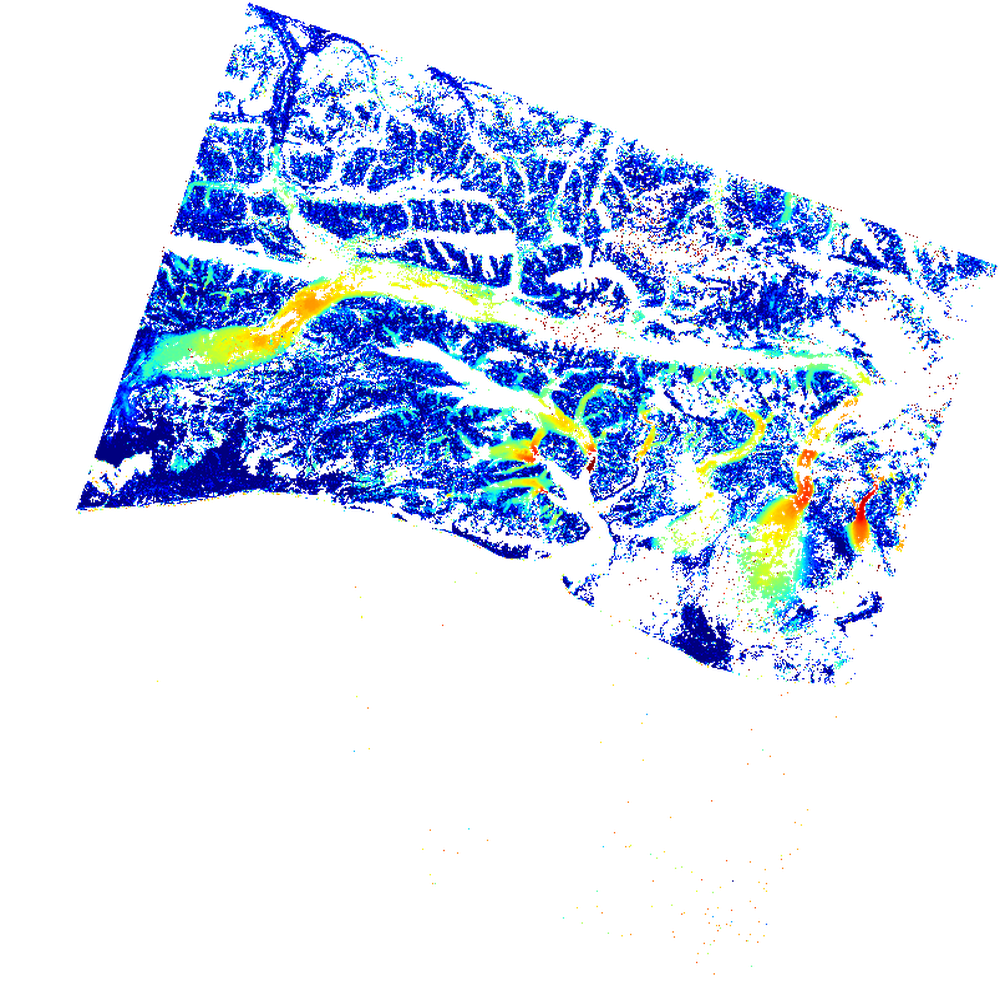

In [6]:
index = 0                   
print('First file: year', year[index], 'day', doy[index])
g.show_local_image('', fpng[index], 1000, 1000)

In [7]:
print(fnc[0])                # print the first netCDF data file name

/home/jovyan/data/golive_big/L8_063_018_016_2013_143_2013_159_v1.1.nc


### Open the NetCDF files using xarray

NetCDF: Network Common Data Form

This opens each `.nc` data file as a separate xarray Dataset appended to list `m[]`.
  
#### BUG
This is poor/naive practice since we can open all 52 .nc files as a single
Dataset using `xr.open_mfdataset()`. However this requires some additional 
finesse so that approach will be adopted in subsequent notebooks `golive2` and `golive3`.

In [8]:
n16s = dur.count(16)    # counts occurrences of '16' in the day-duration list
    
m, m_year, m_doy = [], [], []
    
for f, year, doy in zip(fnc, year, doy):
    if int(f.split('_')[4]) == 16:
        m.append(xr.open_dataset(f))
        m_year.append(year)
        m_doy.append(doy)
    
print('There are', n16s, 'results from 16-day image pairs available\n')
print('First few respective years:', m_year[0:7], 'up to year', m_year[-1])

There are 55 results from 16-day image pairs available

First few respective years: [2013, 2013, 2013, 2014, 2014, 2014, 2014] up to year 2019


## Section 2. Access data

This section explores the NetCDF files, representing them as a list of xarray DataSets `m[]`
for the 16-day-interval results. How to deconstruct these to 'get at' usable numbers 
(glacier speeds for example)?

- Dates involved?
- Coordinates? 
- Data units? Density? Quality? Retrieve velocity profiles at a particular location?
- How do we avoid considering bad data as good data? 
- How to build a time-series visualization?

To begin with simply printing the DataSet object produces a nice text description.

In [9]:
m[0]

<xarray.Dataset>
Dimensions:                                         (chars: 4280, x: 803, y: 786)
Coordinates:
  * x                                               (x) float64 3.373e+05 ... 5.779e+05
  * y                                               (y) float64 6.779e+06 ... 6.544e+06
  * chars                                           (chars) int32 0 1 ... 4279
Data variables:
    image_pair_times                                |S1 ...
    input_image_details                             |S1 ...
    transverse_mercator                             |S1 ...
    offset_correction                               |S1 ...
    applied_bilinear_x_offset_correction_in_pixels  (y, x) float32 ...
    applied_bilinear_y_offset_correction_in_pixels  (y, x) float32 ...
    vx                                              (y, x) float32 ...
    vy                                              (y, x) float32 ...
    vv                                              (y, x) float32 ...
    vx_masked         

In [10]:
meridian = g.get_golive_meridian(m[0])
print('The reference meridian for this UTM zone is', meridian, 'degrees longitude.')

The reference meridian for this UTM zone is -141 degrees longitude.


### Coordinates

In the cell above we call the method `g.get_golive_meridian()` from our utilities module.

The GoLIVE data are in (y, x) Transverse Mercator Coordinates (in meters). 

The y-coordinate is **northing**, x-coordinate is **easting**. 

Let's check on some 
[UTM coordinates](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
on Seward glacier to verify lat/lon correspondence. For reference: [Here is an online UTM calculator](https://www.latlong.net/lat-long-utm.html).

- This gives us Northing, Easting, longitudinal band 7, and latitude band 'V'
- There are 60 longitude bands, each 6 degrees; and 20 latitude bands, each 8 degrees.
- For a few additional pathologies please see the Wikipedia article referenced above.

In [11]:
utm.from_latlon(60.15, -140.45)

(530538.5079323711, 6668243.670375315, 7, 'V')

In [12]:
utm.to_latlon(530538.5079323711, 6668243.670375315, 7, 'V')

(60.150000005547355, -140.44999999728375)

###  Seward glacier transects

Seward Glacier is the primary source of ice feeding into the Malaspina (piedmont lobe) glacier. Seward
consistently shows relatively fast motion flowing along a sinuous path from north to south on the 
eastern side of the image, for example at latitude 60.15 deg N, longitude -140.45 deg W.


#### Inspect some data variables 

The next cell prints some data variables from the first of the six datasets `m[0]`. The
code references four data variables `vv`, `vv_masked`, `corr` and `lgo_mask`. The subsequent square brackets
use a simple tuple of ranges in the manner of a numpy 2D array to pull three values. The final qualifier 
`values` gives actual data rather than describing the nature of the DataArray. (Remove `.values` to see this in action.)

In [13]:
print(m[0]['vv'][493,648:653].values)             # straightforward speeds
print(m[0]['vv_masked'][493,648:653].values)      # masked speeds: Improved by a quality control check
print(m[0]['corr'][493,648:653].values)           # correlation values for the speed calculation
print(m[0]['lgo_mask'][493,648:653].values)       # mask values

[ 0.61901057  2.9667873   0.63096374  0.28799492 32.37187   ]
[      nan 2.9667873       nan       nan       nan]
[0.62321174 0.6002391  0.47392198 0.46754846 0.448105  ]
[0. 0. 0. 0. 0.]


#### Observations on these data values

* The fifth speed given in the first line is 32 meters per day. This is too fast to be correct.
  * very likely this results from a false correlation between the two Landsat 8 source images
  * this source of noise can be either ignored or subjected to additional filtering
* Comparing `vv` to `vv_masked` we see that all but one of the `vv` values is maksed out as a `nan`
* **lgo** stands for **land/glacier/ocean** so it is a terrain mask
  * the `lgo_mask` array has 3 possible values: '0' for glacier, '1' for non-glacier, and '2' for ocean

[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1.]]


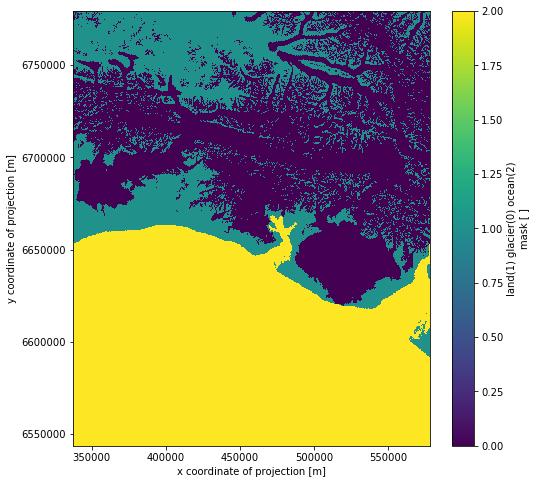

In [19]:
# the lgo_mask variable shows ice (0), land(1) and ocean(2)
print(m[0]['lgo_mask'][0:5,0:5].values)
m[0].lgo_mask.plot(figsize=(8,8))              # an xarray dataset includes a native .plot() method

Here we switch from Dataset m[0] to Dataset m[2] which is a little bit sparser.

UTM coordinate y's are in the 6.6 million range, the x's are in the 500,000 range. A little trial-and-error produced the cropped view shown below: Speeds around Malaspina/Seward/Agassiz Glaciers. 

We use the `.plot()` method from the object of the `.vv_masked` attribute of `m[2]`. Since this composition is a bit mysteriouis let's first print some types so we know what is what...

m[2] is of type <class 'xarray.core.dataset.Dataset'>
.vv_masked is of type <class 'xarray.core.dataarray.DataArray'>
.plot() is of type <class 'xarray.plot.plot._PlotMethods'>


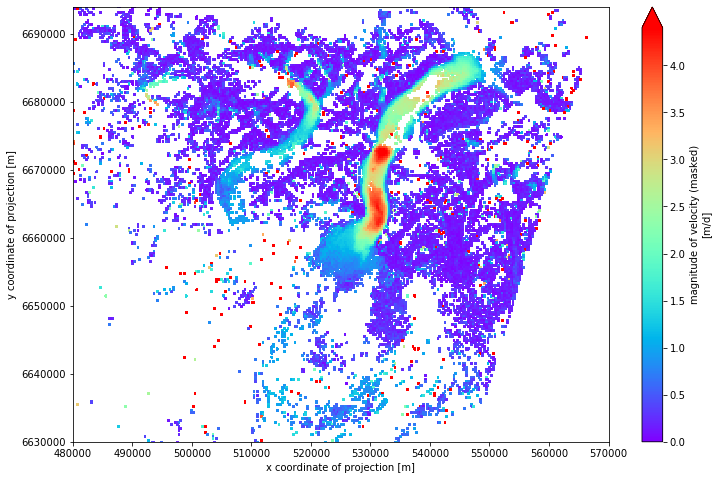

In [18]:
print('m[2] is of type', type(m[2]))
print('.vv_masked is of type', type(m[2].vv_masked))
print('.plot() is of type', type(m[2].vv_masked.plot))

min_speed, max_speed = 0.0, 4.4
p = m[2].vv_masked.plot(figsize=(12,8), cmap=plt.cm.rainbow, vmin=min_speed, vmax=max_speed) # rainbow > bwr blue-white-red

# These next two lines call maplotlib functions through its pyplot API, operating on the default figure. 
#     See https://matplotlib.org/api/api_overview.html
# center on Seward and Malaspina glaciers. Glacier west of Seward is Agassiz.
p = plt.xlim(480000, 570000)
p = plt.ylim(6630000, 6694000)

#### Time

From the self-description of `m` we see an attribute 'image_pair_times'. This in netCDF language is a 
  "data variable" (in contrast to "coordinate variables", dimensions and metadata attributes). Treated in isolation
  it is of type `DataArray`; which means that it has its own Attributes which can be printed like so:

In [19]:
m[2]['image_pair_times']

<xarray.DataArray 'image_pair_times' ()>
array(b'', dtype='|S1')
Attributes:
    del_t:                    16.0
    del_t_units:              days
    del_t_speed_units:        m/d
    start_time_decimal_year:  2013.87123288
    mid_time_decimal_year:    2013.89315068
    end_time_decimal_year:    2013.91506849
    start_date:               2013-11-15T00:00:00
    mid_date:                 2013-11-23T00:00:00
    end_date:                 2013-12-01T00:00:00

In [23]:
# ok let's just get the start_date attribute
m[2]['image_pair_times'].start_date

'2013-11-15T00:00:00'

Next we'd like to go from text fields in the xarray attributes to actual Python time values so we can do time calculations. _A good test is to subtract two times to be sure this works properly_.

For time: Python datetimes work via conversion using 'string parse time' abbreviated 'strptime'

In [21]:
from datetime import datetime

d0 = datetime.strptime(m[2]['image_pair_times'].start_date, '%Y-%m-%dT%H:%M:%S')
d1 = datetime.strptime(m[2]['image_pair_times'].end_date, '%Y-%m-%dT%H:%M:%S')
print(d0)
print(d1)
print('interval is', d1 - d0)

2013-11-15 00:00:00
2013-12-01 00:00:00
interval is 16 days, 0:00:00


#### ipyleaflet map

Plotting data (as above) suggests bringing in a map; for example for generating transects of interest by hand
and verifying that data are located as intended. This is currently not working on the NASA Pangeo JupyterHub. 

In [25]:
print(fpng[0].split('/')[5])

L8_063_018_016_2013_143_2013_159_v1.1.png


In [26]:
from ipyleaflet import (WMSLayer, Map, Marker, MarkerCluster,
    TileLayer, ImageOverlay, Polyline, Polygon, Rectangle, Circle, CircleMarker,
    Popup, GeoJSON, DrawControl, basemaps, Velocity, basemap_to_tiles)
from ipywidgets import Label

# The native map layer has admirable resolution down to building outlines
gmap = Map(center=(60.17567228194297, -141.33636474609378), zoom=8)


# This abandons the native map:
# gmap.clear_layers()

# This defines the working zoom levels (I believe)
# gmap.interact(zoom=(4,15,1))

# This adds a map layer with less resolution but it features both shaded relief and iso elevation lines
# gmap.add_layer(basemaps.Esri.DeLorme)

# An example of creating a Web Mapping Service map layer
# ...roads, water bodies, and buildings 
# wms = WMSLayer(url='https://ows.terrestris.de/osm/service', layers='OSM-Overlay-WMS', tile_size=512)
# gmap.add_layer(wms)

# Hardcoded: Requires a relative, not absolute path to this file
# io = ImageOverlay(url='../data/golive/' + fpng[0].split('/')[5], bounds = gmap.bounds, opacity = 0.5)
io = ImageOverlay(url='../data/golive/L8_063_018_016_2013_143_2013_159_v1.1.png', bounds = gmap.bounds,  opacity = 0.5)
gmap.add_layer(io)
# Use (2-finger) zoom + slide map manipulation to fix the overlay ad hoc

# g = GeoJSON(data=ftif[2])
# velocity = Velocity(data=m[2])

# This works quite well...
# nasa_layer = basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, "2018-04-08");
# gmap.add_layer(nasa_layer);

In [ ]:
# Coregistration note: Attaching an image layer with bounds = gmap.bounds and semi-opacity permits one to move the map
#   under the overlay until features match. Using a readout (see below) would facilitate registering the overlay to 
#   geographic coordinates. 

# Issuing 'gmap' as the last line of the cell brings it up
# Coregister the overlay image by hand if it is offset
#   Use one finger to move map + overlay
#   Use two fingers to resize and slide map to match the overlay
gmap

In [24]:
# This label widget gives a read-out of the coordinate of the mouse cursor
label = Label('----coordinates on map----'); display(label)

def handle_interaction(**kwargs): 
    coordsplit = str(kwargs.get('coordinates')).split()
    coordlat = coordsplit[0].lstrip('[').rstrip(',')
    coordlon = coordsplit[1].rstrip(']')
    coordutm = utm.from_latlon(float(coordlat), float(coordlon))         # returns 4-element tuple northing easting zone-lon zone-lat
    coordlabel = coordlat + ' ' + coordlon
    coordlabel += ' or in UTM: ' + str(coordutm[0]) + ' ' + str(coordutm[1]) + ' ' + str(coordutm[2]) + ' ' + coordutm[3]
    label.value = coordlabel
    
gmap.on_interaction(handle_interaction)

Label(value='----coordinates on map----')

In [29]:
# on the pangeo JHub the overlay is not appearing flag
# These diagnostics ought to (but do not) give a view into the map control
# g.dirnou(gmap)
# g.dirnou(gmap.layers[1])
# print('\n\n')
# gmap.layers[1].get_state
# print('\n\n')
# gmap.get_state

### Concluding part 2

Have...

* a map 
* coordinate access (UTM conversion)
* data mask
* time  
* time series of both data (velocities) and correlation quality
  * speed-as-temperature plot

Need...

* indexing by nearest coordinates 
* a handle on xarray DataSet / DataArray manipulation
  * cf [this Geohackweek link](https://geohackweek.github.io/nDarrays/02-xarray-architecture/)
  * emphasis: xarray DataArrays are extensions of the numpy nDarray n-dimensional array. 
    * 'Extension' in the sense that they have labeled dimensions and coordinates. 
    * gets away from indexing arrays by integers: 0, 1, ..., dim-1.
  * and cf [xarray DataArray official documentation](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html)


The xarray Dataset has four components: `x.dims`, `x.values`, `x.coords`, `x.attrs`; the latter being an ordered dictionary of metadata. The xarray DataArray is similar with the addition of a `name`... anyway this could use a little flag elaboration.


## Section 3. Data visualization and analysis


This section extends data access to interpretation. The key will be the `.nearest()` indexing qualifier 
to translate lat/lon locations to locations of data in a source xarray Dataset where the data are 
indexed in terms of UTM northing/easting. 

Our objective in this section will be to produce a set of speed transects across 
Seward glacier plus a longitudinal speed profile across Malaspina. In all cases across the 
52 available 16-day interval solutions. 

In [27]:
# example of 'nearest' to access a speed data value
northing = 6637657.5
easting = 528142.5
a = m[0]['vv_masked'].sel(y=northing, x=easting, method='nearest')
a.values

array(0.48326758)

In [28]:
# Some transects on Seward Glacier and a longitudinal transect across Malaspina piedmont
#   These coordinates were determined by hand; it would be much better to implement a nice map control
#   to generate them using a point/click interface. 

t_endpoints = []       # transect endpoints: Four across Seward, one longitudinal on Malaspina

t_endpoints.append(((60.104166,-140.478055),(60.079166,-140.421944)))
t_endpoints.append(((60.150833,-140.494444),(60.14611,-140.400277)))
t_endpoints.append(((60.189722,-140.456388),(60.17083,-140.389722)))
t_endpoints.append(((60.242222,-140.417500),(60.21805,-140.300277)))
t_endpoints.append(((60.066388,-140.510555),(59.726944,-140.580555)))

n_t = len(t_endpoints)

utm0 = []
utm1 = []
for i in range(n_t):
    utm0.append(utm.from_latlon(t_endpoints[i][0][0], t_endpoints[i][0][1]))
    utm1.append(utm.from_latlon(t_endpoints[i][1][0], t_endpoints[i][1][1]))

# utm0/1 values are 4-plets for the two endpoints of each transect, each 4 - 40 km in length
# Data posting is nominally 240 meters. We'll over-sample this a bit with 100 meter postings.
from numpy.linalg import norm
posting = 100.

# tr = transect vector across the glacier; tl = transect length; tp = posting-length transect vector
tr  = [(utm1[i][0] - utm0[i][0], utm1[i][1] - utm0[i][1]) for i in range(n_t)]
tl  = [norm(tr[i]) for i in range(n_t)]
tp  = [tr[i] / tl[i] * posting for i in range(n_t)]
nps = [int(tl[i] / posting) + 1 for i in range(n_t)]


print(utm0, '\n')       # notice these 4-tuples are (easting, northing, lon-band, lat-band)
print(tr, '\n')
print(tl, '\n')
print(tp, '\n')
print(nps, '\n')
print(tr, '\n')
print(tl, '\n')
print(tp, '\n')
print(nps, '\n')

[(529021.1110697987, 6663126.611153034, 7, 'V'), (528070.0981115395, 6668316.724012578, 7, 'V'), (530147.4105949326, 6672664.497006416, 7, 'V'), (532252.417105228, 6678529.731215285, 7, 'V'), (527245.2259248154, 6658905.556669951, 7, 'V')] 

[(3144.1744930562563, -2758.1968929581344), (5233.141818051343, -482.24623928405344), (3716.5123229203746, -2071.6535719921812), (6518.903660722659, -2628.9233719613403), (-3657.135517305869, -37828.78888074588)] 

[4182.521170670804, 5255.314902376576, 4254.904507596729, 7029.03571149186, 38005.156339317735] 

[array([ 75.17414413, -65.94579634]), array([99.57808267, -9.17635286]), array([ 87.3465507 , -48.68860319]), array([ 92.74250307, -37.40091073]), array([ -9.6227351 , -99.53593808])] 

[42, 53, 43, 71, 381] 

[(3144.1744930562563, -2758.1968929581344), (5233.141818051343, -482.24623928405344), (3716.5123229203746, -2071.6535719921812), (6518.903660722659, -2628.9233719613403), (-3657.135517305869, -37828.78888074588)] 

[4182.521170670804, 

[(0.0, 8.0)]

[Text(0, 0.5, 'm / d'), Text(0.5, 0, 'transect 1')]

[(0.0, 8.0)]

[Text(0, 0.5, 'm / d'), Text(0.5, 0, 'transect 2')]

[(0.0, 8.0)]

[Text(0, 0.5, 'm / d'), Text(0.5, 0, 'transect 3')]

[(0.0, 8.0)]

[Text(0, 0.5, 'm / d'), Text(0.5, 0, 'transect 4')]

[(0.0, 8.0)]

[Text(0, 0.5, 'm / d'), Text(0.5, 0, 'transect 5')]

100%|██████████| 5/5 [00:51<00:00, 10.32s/it]


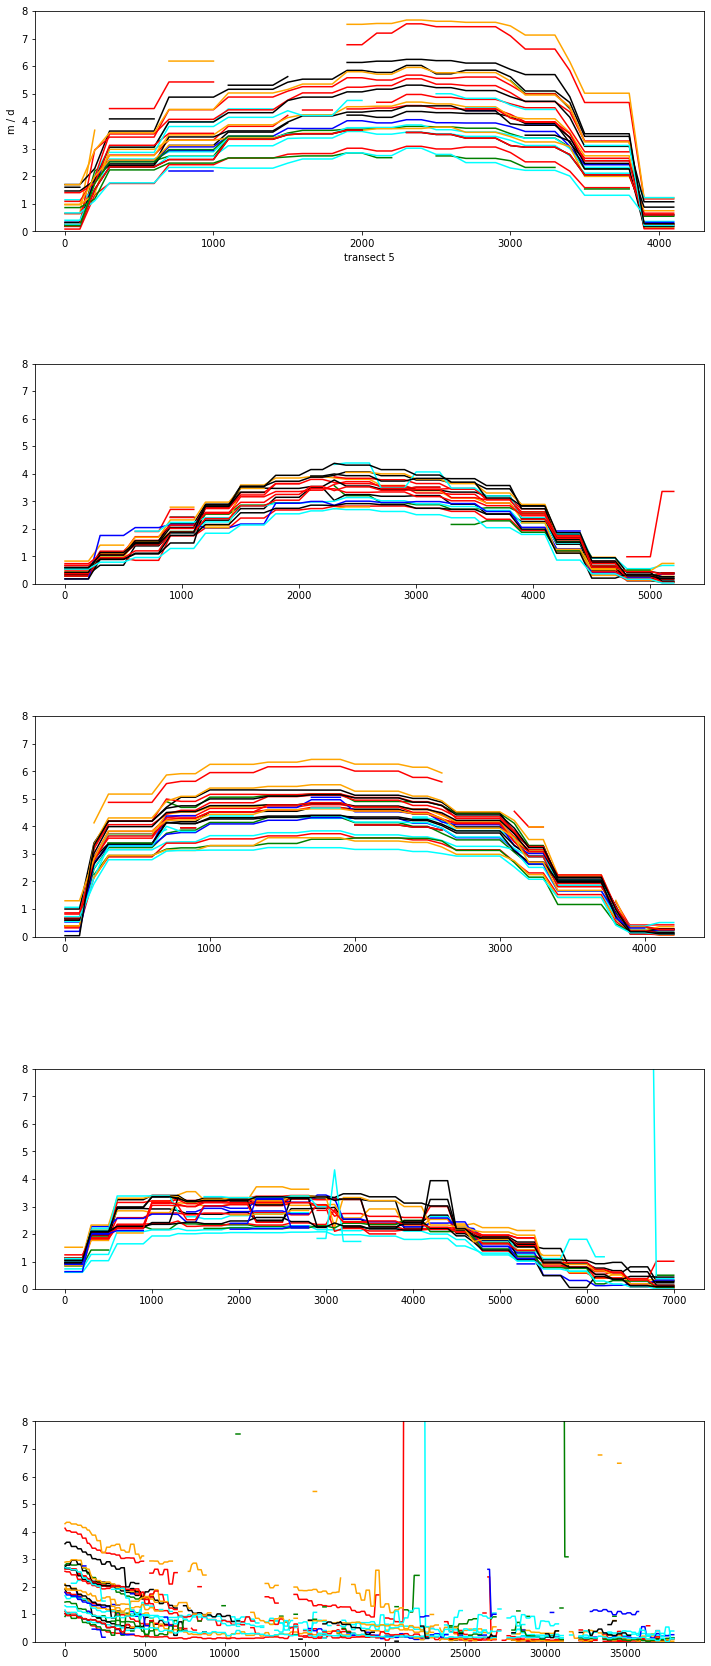

In [37]:
# Remember that n16s is how many 16-day-interval results we have; and these are m[0], ..., m[n16s - 1]
colorsequence = ['red', 'orange', 'green', 'cyan', 'blue', 'black']
ncol = len(colorsequence)
fig, axes = plt.subplots(n_t, figsize=(1,1))
fig.set_size_inches(12,30)
# Don't need axes[0].axis('equal') as this is not geometry
for i in range(n_t): 
    axes[i].set(ylim=(0., 8.))     # some center speeds will exceed this speed (m/d)...
    axes[0].set(xlabel='transect ' + str(i + 1), ylabel = 'm / d')

# plt.subplots_adjust(bottom=-.2, top=1.2)
p = plt.subplots_adjust(hspace=0.6)

# plot(x-list, y-list)
x = []
y = []

# the four Seward transect charts
for t in tqdm(range(n_t)):                           # loop over the sub-plots
    for j in range(n16s):                    # for each one loop over the number of speed results
        # 52 x 5 takes about two minutes...
        s = [float(m[j]['vv_masked'].sel(y=utm0[t][1] + float(i) * tp[t][1], 
                                         x=utm0[t][0] + float(i) * tp[t][0], 
                                         method = 'nearest').values) for i in range(nps[t])]
        d = [float(i) * posting for i in range(nps[t])]
        p = axes[t].plot(d, s, color=colorsequence[j % ncol])

# color-coded time labels for Seward transects
# This is commented out: It is useful for a small number of transects but just clutter for 52 results
# xoff=[]
# for t in range(nT):
#     for j in range(n16s):
#         axes[t].text(0, 5.5 - 0.3*j, str(year[j]) + ' ' + str(doy[j]), color=colorsequence[j%ncol])

### Create time-series plots for speeds at just the *center* of the each transect

With perfect data this would be 52 datapoints per chart, one for each result. However as noted the data are lossy due to clouds and so on; so the resulting charts have typically about 20 results each. By widening the scope to *any* time interval (not just 16 days) we get more complete records. This is deferred to the next notebook.

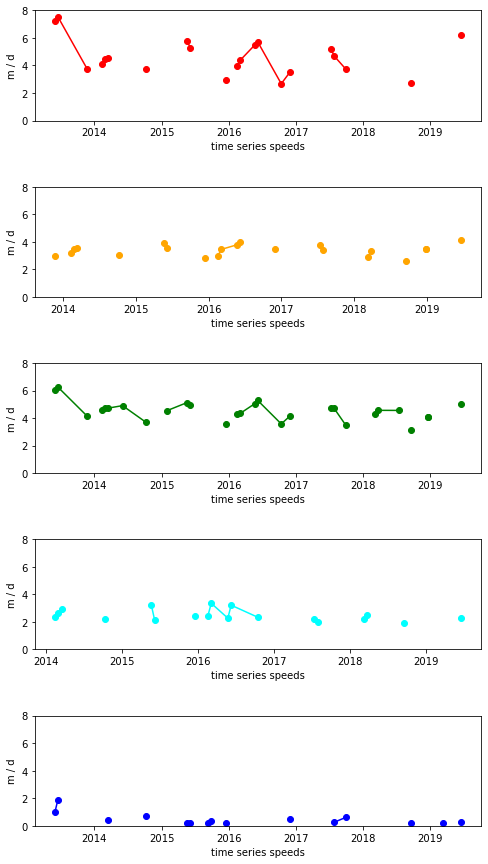

In [43]:
# Remember that n16s is how many 16-day-interval results we have; and these are m[0], ..., m[n16s - 1]
fig, axes = plt.subplots(n_t)
fig.set_size_inches(8,15)
for i in range(n_t): 
    p = axes[i].set(ylim=(0., 8.))
    p = axes[i].set(xlabel='time series speeds', ylabel = 'm / d')
plt.subplots_adjust(hspace=0.6)

# flag this is bad code
x, y = [[],[],[],[],[]], [[],[],[],[],[]]

x_mid = [utm0[t][0] + (nps[t]/2.)*tp[t][0] for t in range(n_t)]
y_mid = [utm0[t][1] + (nps[t]/2.)*tp[t][1] for t in range(n_t)]

for t in range(n_t): 
    for j in range(n16s):
        x[t].append(float(m[j]['image_pair_times'].mid_time_decimal_year))   # or Datetime(...mid_date)
        y[t].append(m[j]['vv_masked'].sel(y=y_mid[t], x=x_mid[t], method='nearest').values)
        
for i in range(n_t):
    p = axes[i].plot(x[i], y[i], 'o-', color=colorsequence[i])
        

### Overlaying information and adding interactivity

To verify these transects are located correctly we next draw them on the speed plot with labels.  
Further we configure sliders to control the color map range for adjustable emphasis. 
Sliders are from the ipywidgets Python package.

In [46]:
from ipywidgets import interact
from ipywidgets import *
from traitlets import dlink

def show_roi_with_overlays(lowerColor, upperColor):
    # Verify the transects are where we think they are
    #   cf (on xarray.plot() overlay) http://xarray.pydata.org/en/stable/auto_gallery/plot_cartopy_facetgrid.html
    p = m[0].vv_masked.plot(figsize=(12,8),cmap=plt.cm.rainbow,vmin=lowerColor, vmax=upperColor) # rainbow > bwr blue-white-red
    ax = p.axes

    # the first index is the transect index: 0, 1, 2, 3
    for j in range(n_t): 
        xxx = [utm0[j][0] + float(i) * tp[j][0] for i in range(nps[j])]
        yyy = [utm0[j][1] + float(i) * tp[j][1] for i in range(nps[j])]
        ax.plot(xxx, yyy, 'k')
    
    # label the transects: Positions determined by trial and error (flag this is more hardcoding)
    ax.text(525800, 6663500, '1', fontsize = '12', color='black', backgroundcolor='white', weight='bold')
    ax.text(535000, 6667000, '2', fontsize = '12', color='black', backgroundcolor='white', weight='bold')
    ax.text(527100, 6674000, '3', fontsize = '12', color='black', backgroundcolor='white', weight='bold')
    ax.text(528600, 6679000, '4', fontsize = '12', color='black', backgroundcolor='white', weight='bold')
    ax.text(528000, 6650000, 'longitudinal', fontsize = '10', color='black', backgroundcolor='white', weight='bold')

    # focus on the interesting part of the image...
    plt.xlim(480000,570000)
    plt.ylim(6630000,6694000)

p = interact(show_roi_with_overlays, 
                 lowerColor=widgets.FloatSlider(min=0.00,max=5.975,step=.025,\
                                            value=0.0, continuous_update=False, readout_format='1.4f', \
                                            description='lower color'),       
                 upperColor=widgets.FloatSlider(min=0.05,max=6.0,step=.025,\
                                            value=4.0, continuous_update=False, readout_format='1.4f', \
                                            description='upper color')
        )

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='lower color', max=5.975, re…

In [35]:
# minimum to maximum reasonable speeds range about 0 to 10 meters per day
# mspeed[0:20,0:20].values gives lots of nans
# a=mspeed[400:410,600:610]
# print(a.values)
# print(~np.isnan(a).values)

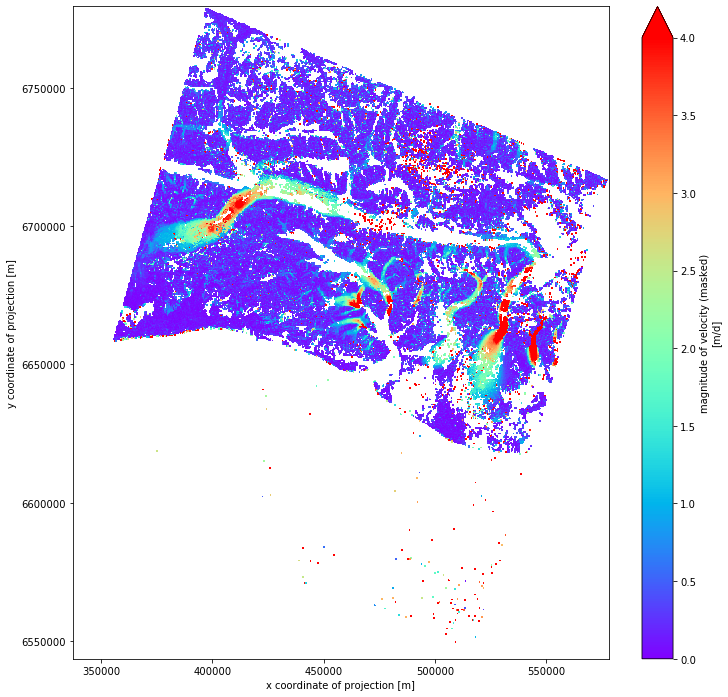

In [47]:
from numpy import isnan

# masked speed, entire image
speed = m[0].vv_masked   # _masked: corr and del_corr thresholds applied; not the lgo mask (land/glacier/ocean)
p = speed.plot(figsize=(12,12),cmap=plt.cm.rainbow,vmin=0.0, vmax=4.0)

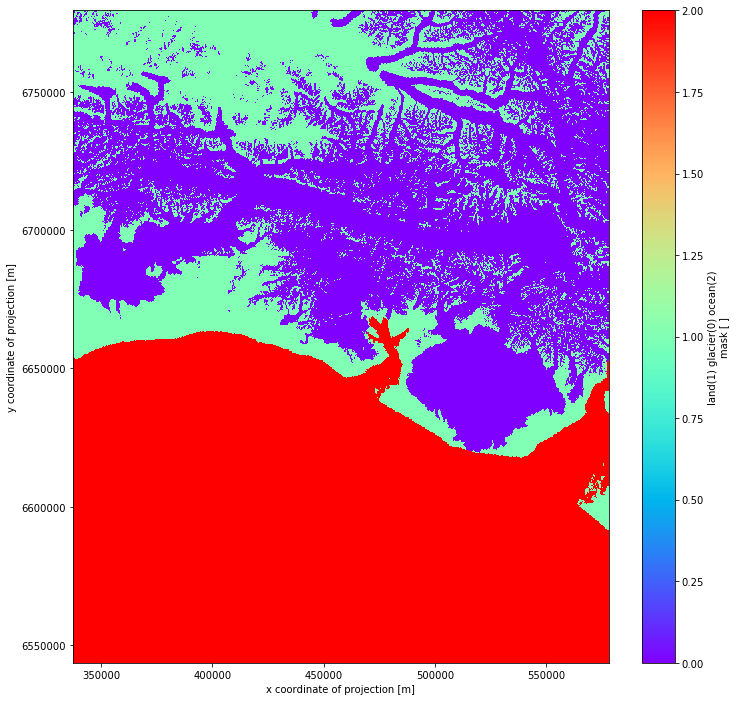

In [48]:
# land / glacier / ocean mask
lgo = m[0].lgo_mask
p = lgo.plot(figsize=(12,12),cmap=plt.cm.rainbow,vmin=0.0, vmax=2.0)

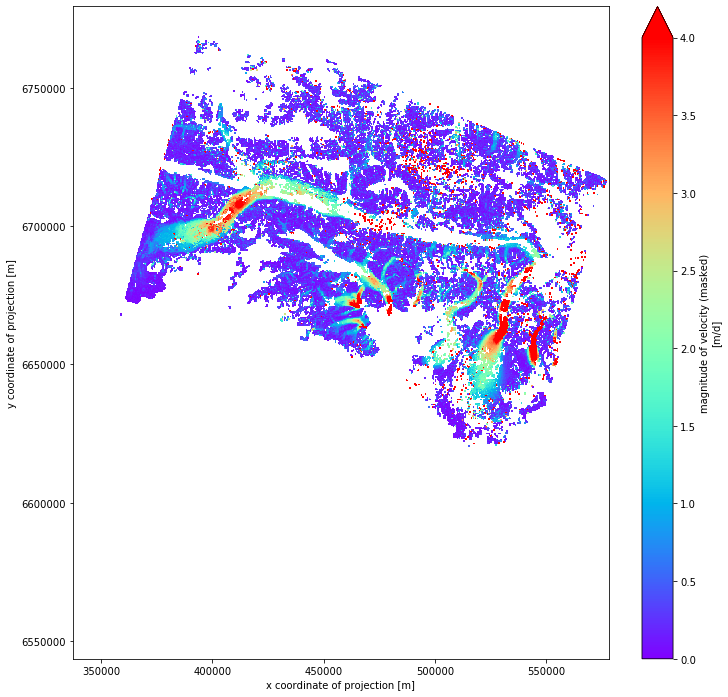

In [49]:
# redact the speed field by applying the lgo mask
mspeed = speed.where(lgo == 0.)        # mspeed is shorthand for masked speed, i.e. masked now by lgo_mask
p = mspeed.plot(figsize=(12, 12), cmap=plt.cm.rainbow, vmin=0.0, vmax=4.0)

<class 'xarray.core.dataarray.DataArray'> <class 'xarray.core.dataarray.DataArray'>
True


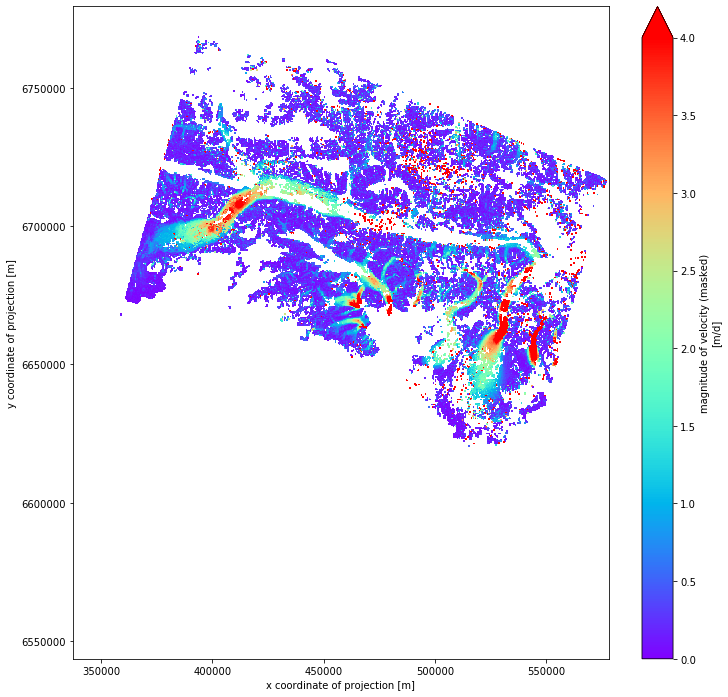

In [50]:
# The next line is intended to filter out NaN values but as you can see tmp1 == mspeed so it does nothing
tmp1 = mspeed.where(~isnan(mspeed))
p = tmp1.plot(figsize=(12,12), cmap=plt.cm.rainbow, vmin=0.0, vmax=4.0)
print(type(mspeed), type(tmp1))           # both DataArrays
print(tmp1.equals(mspeed))                # True, meaning they are equal

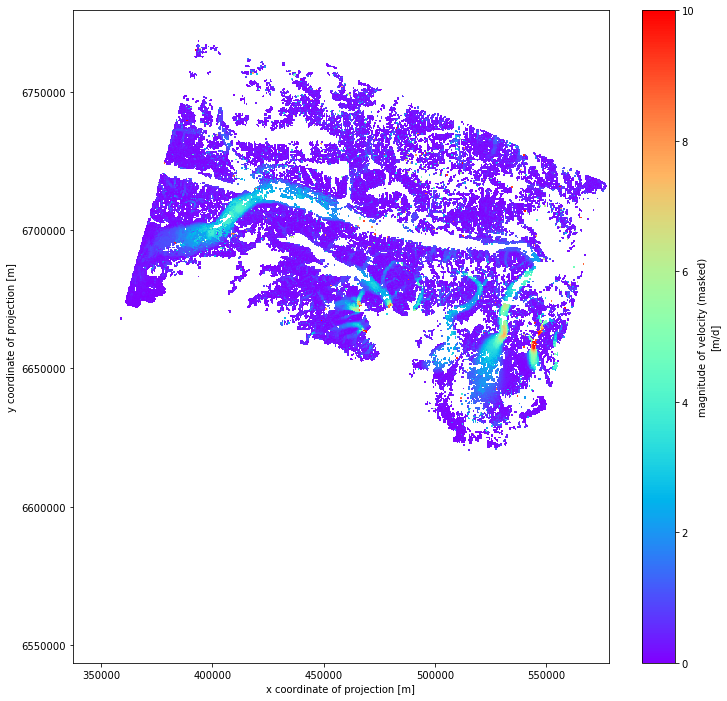

In [51]:
# for comparison: out_vec = out_vec[~numpy.isnan(out_vec)] 
np.warnings.filterwarnings('ignore')            # numpy is throwing a warning because of the NaN values
topspeed = 10.0                                 # meters per day... 6 is probably more physically realistic
mbspeed = tmp1.where(tmp1 < topspeed)           # mbspeed is shorthand for masked, bounded speed
p = mbspeed.plot(figsize=(12,12), cmap=plt.cm.rainbow, vmin=0.0, vmax=topspeed)

Let's use the histogram feature of DataArrays (or maybe xarray nDarrays? pandas?...) 
to view two aspects of speed versus mbspeed side-by-side.
- First how does the long tail of very high speeds compare? 
- Second how does the mask + bound process curtail mspeed for the bulk of the (< 1 m/d) data?

This cell also accomplishes something very important (difficult to discern) in the plotting
  tutorial: It takes the native `hist` method of the DataArray and combines that with a 
  subplot layout. Notice that the subplots are 2 x 2 and the corresponding axes are 
  indexed `[0,1]` etcetera. These axes are assigned to the histogram inside the `.plot.hist()`
  call native to DataArray's 'speed' and 'mbspeed'. 

Histograms showing (right) application of lgo_mask and speed bounds to vv_masked speed (left).
  A couple thousand points with speeds above five meters per day are culled to 500 or so...
  A hundred thousand or so data values are discarded with low-speed.


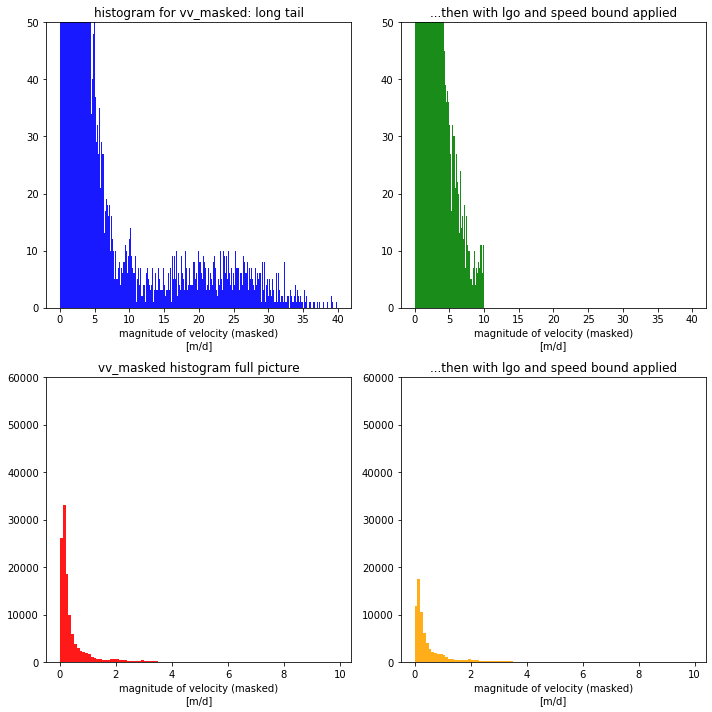

In [53]:
fig, axes = plt.subplots(2, 2, tight_layout=True, figsize=(10,10))

hinc = 0.1               # histogram increment
s0 = 0.                  # low-end speed
big_s1 = 40.             # high-end speed for the low-count histogram (upper row)
small_s1 = 10.           # high-end speed for the high-count histogram (lower row)
small_hi_count = 50.     # max for y-range on the low-count histogram
big_hi_count = 60000.    # max for y-range on the high-count histogram

p = speed.plot.hist(ax=axes[0,0], bins=np.arange(s0,big_s1,hinc), alpha=0.9, color='blue')
p = mbspeed.plot.hist(ax=axes[0,1], bins=np.arange(s0,big_s1,hinc), alpha=0.9, color='green')
p = speed.plot.hist(ax=axes[1,0], bins=np.arange(s0,small_s1,hinc), alpha=0.9, color='red')
p = mbspeed.plot.hist(ax=axes[1,1], bins=np.arange(s0,small_s1,hinc), alpha=0.9, color='orange')
p = axes[0,0].set(ylim=(0., small_hi_count))
p = axes[0,1].set(ylim=(0., small_hi_count))
p = axes[1,0].set(ylim=(0., big_hi_count))
p = axes[1,1].set(ylim=(0., big_hi_count))
p = axes[0,0].set(title='histogram for vv_masked: long tail')
p = axes[0,1].set(title='...then with lgo and speed bound applied')
p = axes[1,0].set(title='vv_masked histogram full picture')
p = axes[1,1].set(title='...then with lgo and speed bound applied')

print('Histograms showing (right) application of lgo_mask and speed bounds to vv_masked speed (left).')
print('  A couple thousand points with speeds above five meters per day are culled to 500 or so...')
print('  A hundred thousand or so data values are discarded with low-speed.')


## Section 4. Conclusions for this notebook

On mechanics...

- We have here steps in data retrieval (to the local environment), unpacking and charting
- The approach used was typical of former, not current practice
  - Each data file was mapped to a separate xarray Dataset as a list
  - The data used were from a single path-row frame from Landsat8
  - The data used were 16-day time interval only (not 32, 48, 64, 80, 96 day)
  - The analysis concerned only a small set of locations: 5 transects 
  - The next notebook will improve on these restrictions
- Data are noisy but are susceptible to filtering schemes as the above histograms demonstrate


On glaciology...

- Glacier speed seasonal variability is suggested by the data
- Lateral transects on Seward and the longitudinal profile of Malaspina appear reasonable; with some noise 
- Seward shows longitudinal variability in speed
- An 'agenda item' is to move from glacier-scale inquiry' to regional scale

